<a href="https://colab.research.google.com/github/IshaanKetchup/ASLtoEnglish/blob/main/OCR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def preprocess_for_segmentation(image_path):
    """
    Load and preprocess image for letter segmentation
    """
    # Load image and convert to grayscale
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Invert colors (EMNIST expects white on black)
    img = 255 - img

    # Threshold to binary
    _, thresh = cv2.threshold(img, 30, 255, cv2.THRESH_BINARY)

    return thresh

def segment_letters(image_path, min_contour_area=100):
    """
    Segment an image containing multiple letters into individual letter images
    Returns list of segmented letter images
    """
    # Preprocess image
    processed_img = preprocess_for_segmentation(image_path)

    # Find contours
    contours, _ = cv2.findContours(processed_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    letter_images = []
    bounding_boxes = []

    for contour in contours:
        # Filter small contours (noise)
        if cv2.contourArea(contour) < min_contour_area:
            continue

        # Get bounding box
        x, y, w, h = cv2.boundingRect(contour)

        # Extract letter
        letter = processed_img[y:y+h, x:x+w]

        # Add padding to make it square
        size = max(w, h)
        padded = np.zeros((size, size), dtype=np.uint8)
        x_offset = (size - w) // 2
        y_offset = (size - h) // 2
        padded[y_offset:y_offset+h, x_offset:x_offset+w] = letter

        # Resize to 28x28 (EMNIST size)
        resized = cv2.resize(padded, (28, 28), interpolation=cv2.INTER_AREA)

        letter_images.append(resized)
        bounding_boxes.append((x, y, w, h))

    # Sort letters from left to right
    letter_images = [img for _, img in sorted(zip([box[0] for box in bounding_boxes], letter_images))]

    return letter_images

def prepare_for_prediction(letter_image):
    """
    Prepare a segmented letter image for prediction
    Applies EMNIST-specific transformations (flip and rotate)
    """
    # Convert to PIL Image
    img = Image.fromarray(letter_image)

    # Apply EMNIST transformations
    img = img.transpose(Image.FLIP_LEFT_RIGHT)  # Horizontal flip
    img = img.rotate(90, expand=True)           # Rotate 90 degrees left

    # Convert to tensor
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    return transform(img).unsqueeze(0).to(device)

def predict_multiple_letters(image_path, show_segmentation=False):
    """
    Full pipeline for multi-letter OCR prediction
    """
    # Segment letters
    letters = segment_letters(image_path)

    if show_segmentation:
        # Display segmentation results
        plt.figure(figsize=(12, 3))
        for i, letter in enumerate(letters):
            plt.subplot(1, len(letters), i+1)
            plt.imshow(letter, cmap='gray')
            plt.axis('off')
        plt.suptitle("Segmented Letters")
        plt.show()

    predictions = []

    # Predict each letter
    for i, letter in enumerate(letters):
        # Prepare image for model
        letter_tensor = prepare_for_prediction(letter)

        # Make prediction
        with torch.no_grad():
            outputs = model(letter_tensor)
            probabilities = torch.nn.functional.softmax(outputs, dim=1)
            confidence, predicted = torch.max(probabilities, 1)

        predicted_char = class_to_char[predicted.item()]
        confidence = confidence.item()

        predictions.append((predicted_char, confidence))

        if show_segmentation:
            # Display each letter with prediction
            plt.figure()
            plt.imshow(letter, cmap='gray')
            plt.title(f"Predicted: {predicted_char}\nConfidence: {confidence:.2%}")
            plt.axis('off')
            plt.show()

    return predictions

In [ ]:
image_path = "apple.png"
predictions = predict_multiple_letters(image_path, show_segmentation=False)
parsedStr = ""
print("\nFinal Predictions:")
for i, (char, confidence) in enumerate(predictions):
    print(f"Letter {i+1}: {char} (confidence: {confidence:.2%})")
    parsedStr+=char

print(parsedStr)


Final Predictions:
Letter 1: A (confidence: 99.94%)
Letter 2: P (confidence: 96.70%)
Letter 3: P (confidence: 99.37%)
Letter 4: l (confidence: 74.22%)
Letter 5: e (confidence: 66.86%)
APPle


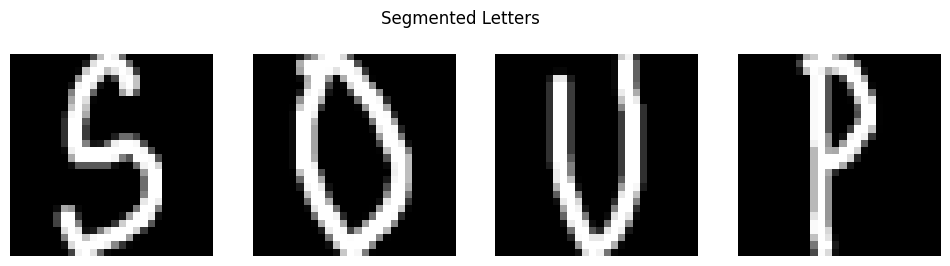

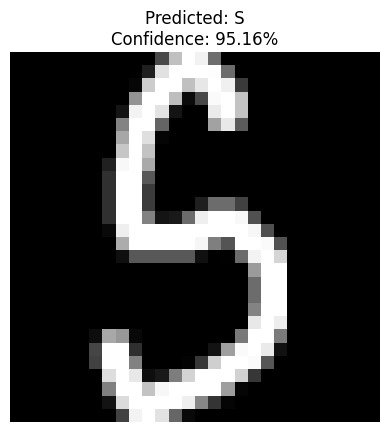

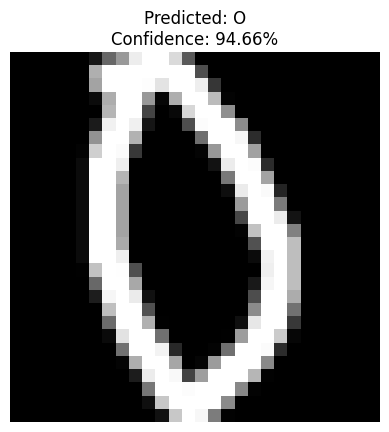

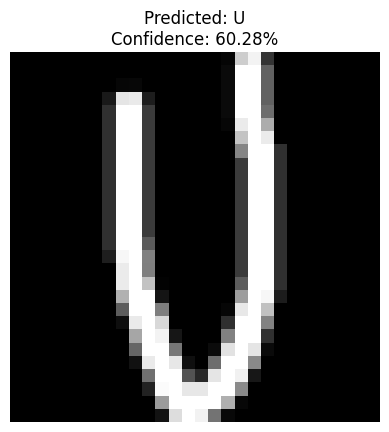

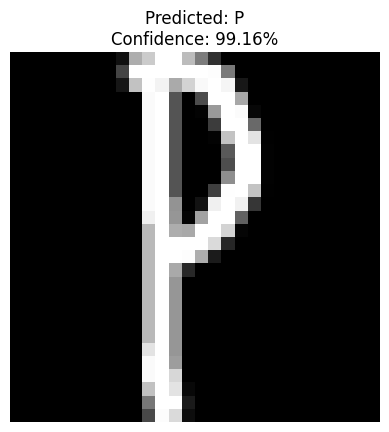


Final Predictions:
Letter 1: S (confidence: 95.16%)
Letter 2: O (confidence: 94.66%)
Letter 3: U (confidence: 60.28%)
Letter 4: P (confidence: 99.16%)
SOUP


In [ ]:
image_path = "soup.png"
predictions = predict_multiple_letters(image_path, show_segmentation=True)
parsedStr = ""
print("\nFinal Predictions:")
for i, (char, confidence) in enumerate(predictions):
    print(f"Letter {i+1}: {char} (confidence: {confidence:.2%})")
    parsedStr+=char

print(parsedStr)